# INTRODUCTION

# Final Project for INFO2950
# Group members: Chris Chen, Michael Schwartz, Will Bekerman

## Info about files:
- **scraper_TopCharts.ipynb:** this is the scraper that was used to scrape data off of Spotify’s top charts webpages starting from 1/1/17 until 4/13/20 (ex: https://spotifycharts.com/regional/us/daily/2020-03-22). These pages only contain basic information about each song, such as the song’s rank on the given day, its number of streams, its title, and the artist. After running the scaper, the final dataset was stored in the **TopCharts_incomplete.csv** file.

- **scraper_AudioFeatures.ipynb:** this is the scraper that was used to retrieve audio features (such as Tempo, Valence, Energy etc.) for each song in the **TopCharts_incomplete.csv** using Spotify’s API. After I ran this scraper, some queries returned nothing, resulting in the dataset containing NA values. This data was stored in the **TopCharts_missing.csv** file. I then fixed some of the errors, but others persisted (possibly because those songs no longer exist on Spotify).The resulting data is stored in the TopCharts_complete.csv file.
  - Spotify's documentation on audio features: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

- **TopCharts_incomplete.csv:** scraped directly from Spotify's Top Charts website; does not contain audio features
- **TopCharts_missing.csv:** first round of retrieving audio features; some songs may be missing audio features
- **TopCharts_complete.csv:** complete dataset with all audio features
- **TopCharts.csv:** complete dataset with all audio features and streams converted to int datatype
- **TopCharts_clustered_artists.csv:** dataset with all unique artists, their median audio feature values, and their cluster assignments
- **TopCharts_clustered_songs.csv:** dataset with all unique songs and their cluster assignments

## Some issues regarding the dataset:

- Spotify doesn’t have Top Charts webpages for the following dates:
  - 2017-05-30
  - 2017-05-31
  - 2017-06-02
- Some Top Charts webpages have missing values for the artist and song name (ex: ranks 8, 16, 33, 63 on https://spotifycharts.com/regional/us/daily/2017-07-20). The rows with missing artist and songs names were ignored during scraping.
Some songs on past Top Charts don’t show up when searched for using Spotify’s query feature. However, these songs comprise a very small portion of our entire dataset (<2%), so we decided to exclude them in our final dataset (these missing songs are listed at the bottom of the scraper_AudioFeatures.ipynb file)
There are duplicates in the CSV files (one row for each day a song is on the top charts), which could make the dataset hard to work with
For example, when we examine the top song for each week, if the same song is still at the top, this could potentially confound our model of the change over time of the top song

## Writeup 
* __What is the context of the work? What research question are you trying to answer? What are your main findings?__ 
    * We are looking to answer a variety of research questions:
        * One question we have relates to the popularity of songs over time. We plan to model and analyze the number of weekly streams for a given song based on its features
        * Another question we have is how audio features for top songs have changed over time. We plan to use statistical methods to analyze how the musical attributes among top songs change over time.  
        * Finally, we also plan to examine the relationship between audio features in popular songs. We plan to analyze the correlation between these features
        * We also hope to visualize the songs and their attributes using clustering methods such as PCA and t-SNE.


Data description. This should be inspired by the format presented in Gebru et al, 2018. Answer the following questions:

* __What are the observations (rows) and the attributes (columns)?__
    * Observations-- songs
    * Features -- song attributes (e.g., artist, title, streams), audio features (e.g., key, loudness, tempo)
* __Why was this dataset created?__
    * The reason this dataset was created was for the Top Charts on Spotify -- Top 200 or playlist with the most listened to songs.
* __Who funded the creation of the dataset?__
    * Spotify AB -- operates as a music streaming service company and offers digital music on media outlets such as computers, phones, and tablets
* __What processes might have influenced what data was observed and recorded and what was not?__
    * Airplay - if a song is repeatedly played on the radio, most likely on the top charts. Tracked through Broadcast Data Systems (BDS) - to identify songs that are on radio and TV channels across the US
    * Social Media/ Streaming - social interactions with Twitter, Facebook, Youtube, etc. 
    * Album Sales - Nielsen SoundScan, an information system that tracks sales of music by scanning barcodes for such sources as online stores to concert sales. 
* __What preprocessing was done, and how did the data come to be in the form that you are using?__
    * First, we scraped directly from Spotify's Top Charts website and got the top 200 songs on Spotify for a given date
    * Next, we retrieved audio features for each song using Spotify’s API and rendered a complete dataset of songs with stream measures and audio features
    * For our final dataset, we also removed songs that cannot be currently found on Spotify
* __If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?__
* Yes, people are aware of the data collection. The data was collected with Spotify, and they have a Terms and Conditions agreement which allows them to collect user data. The users expect the data to be used for personalized recommendations.

* __Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box).__
    * The scraped dataset can be found here (https://github.com/chriscc447/info2950_final); it is titled TopCharts_complete.csv
    * It is also available in our Google Drive folder.
    * The raw data is split into two parts. The first part is basic data about each song, and can be found on Spotify's Top Charts webpages (ex: https://spotifycharts.com/regional/us/daily/2020-03-22). The second part is the audio features for each song, and can be found by using the query feature that is accessible via the Spotify API.

# ANALYSIS

In [1]:
# Import all libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import seaborn as sn
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import chisquare
from pprint import PrettyPrinter

pp = PrettyPrinter(indent = 4)

# Modeling Song Popularity: Linear Regression

Let's see if we can use a __model a song's popularity using a linear regression model with the song's audio features as predictor variables__. Based on our intuition, we expect energy and danceability to be positively correlated with popularity, as songs with higher energy/danceability tend to be played more frequently on the radio and at parties/social gatherings.

First, we reorganize our dataset so we only have one song per row, rather than one song per row per day. Since a song's audio features don't change from day to day, we don't need to worry about changing those variables in the new dataframe. However, there are some time-dependent variables that need to be summarized in the new dataframe. They are listed below:
* __days__ = number of times the song shows up in the original dataframe
* __peak_streams__ = maximum number of times the song was streamed
* __median_streams__ = median [...]
* __peak_rank__ = highest rank the song achieved while it was on the charts
* __median_rank__ = median [...]

*There are many other summary statistics I could have used to aggregate the data -- I chose to look at the __median__ for robustness against outliers and the maximums (peaks) to get a snapshot of the exactly how popular a song became in its time in the charts.*

In [5]:
all_df = pd.read_csv("data/TopCharts.csv").dropna().reset_index(drop = True) # import data
unique_songs_df = all_df.drop_duplicates(subset = ['uri']).copy() # each song only appears once
for uri in unique_songs_df.uri:
    song_subset = all_df.loc[all_df.uri == uri, :]
    unique_songs_df.loc[unique_songs_df.uri == uri, 'days'] = len(song_subset)
    unique_songs_df.loc[unique_songs_df.uri == uri, 'peak_streams'] = song_subset.streams.max()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'median_streams'] = song_subset.streams.median()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'peak_rank'] = song_subset['rank'].min()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'median_rank'] = song_subset['rank'].median()

unique_songs_df.drop(columns = ['streams', 'rank', 'date'], inplace = True)

In [6]:
# re-arrange order of columns
unique_songs_df = unique_songs_df[['peak_rank', 'median_rank', 'days', 'peak_streams', 'median_streams'] + list(unique_songs_df.columns[:-5].values)]

In [4]:
unique_songs_df.head() # see first five rows of dataframe

,peak_rank,median_rank,days,peak_streams,median_streams,artist,title,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature
0,1.0,71.0,429.0,1823391.0,309115.0,Migos,Bad and Boujee (feat. Lil Uzi Vert),0.927,0.665,11.0,...,1.0,0.2440,0.061,0.000000,0.123,0.175,127.076,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,343150.0,4.0
1,2.0,96.0,455.0,1428332.0,249886.0,Drake,Fake Love,0.928,0.481,9.0,...,0.0,0.2870,0.105,0.000000,0.176,0.613,134.007,spotify:track:343YBumqHu19cGoGARUTsd,210937.0,4.0
2,3.0,101.5,464.0,1134858.0,248945.0,The Weeknd,Starboy,0.679,0.587,7.0,...,1.0,0.2760,0.141,0.000006,0.137,0.486,186.003,spotify:track:7MXVkk9YMctZqd1Srtv4MB,230453.0,4.0
3,4.0,119.0,536.0,1010492.0,245003.0,The Chainsmokers,Closer,0.748,0.524,8.0,...,1.0,0.0338,0.414,0.000000,0.111,0.661,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,244960.0,4.0
4,5.0,101.0,240.0,874289.0,267720.0,Rae Sremmurd,Black Beatles,0.794,0.632,0.0,...,1.0,0.0649,0.142,0.000000,0.128,0.355,145.926,spotify:track:6fujklziTHa8uoM5OQSfIo,291893.0,4.0


Let's save this processed dataframe as a CSV file so we don't need to go through the preprocessing steps again in the future. 

In [5]:
unique_songs_df.to_csv("data/TopCharts_unique_songs.csv", index = False)  # write to CSV

Let's try to __measure popularity using the number of days a song appeared on the charts__. Here's a look:

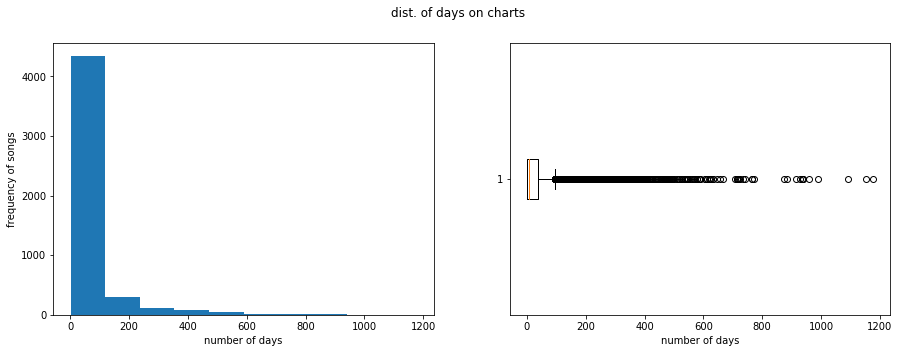

count    4899.000000
mean       48.210655
std       108.815695
min         1.000000
25%         2.000000
50%         7.000000
75%        39.000000
max      1177.000000
Name: days, dtype: float64

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # set up two separate figures and display side-by-side
ax1.hist(unique_songs_df.days)
ax1.set_xlabel("number of days")
ax1.set_ylabel("frequency of songs")
ax2.boxplot(unique_songs_df.days, vert = False)
ax2.set_xlabel("number of days")
fig.suptitle("dist. of days on charts")
plt.show()

unique_songs_df.days.describe() # summary statistics of 'days' feature

We see that the distribution of the number of days that songs appear on the charts is __extremely right skewed__, with most songs staying on the charts for fewer than 40 days. Let's log-transform the number of days to try and lessen the skew:

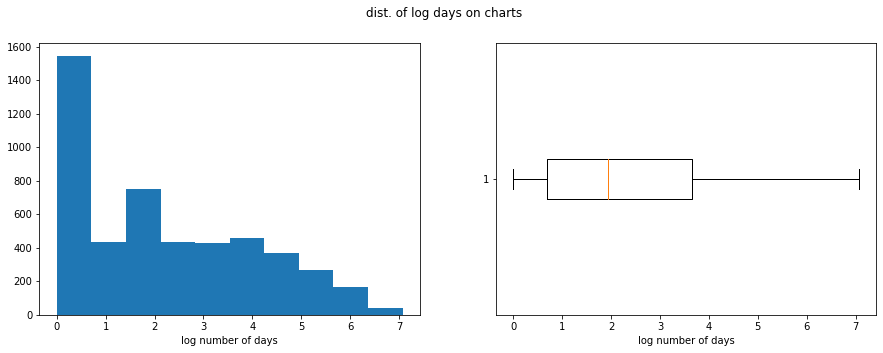

count    4899.000000
mean        2.221325
std         1.830212
min         0.000000
25%         0.693147
50%         1.945910
75%         3.663562
max         7.070724
Name: days, dtype: float64

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # set up two separate figures and display side-by-side
ax1.hist(np.log(unique_songs_df.days))
ax1.set_xlabel("log number of days")
ax2.boxplot(np.log(unique_songs_df.days), vert = False)
ax2.set_xlabel("log number of days")
fig.suptitle("dist. of log days on charts")
plt.show()

np.log(unique_songs_df.days).describe() # summary statistics of log-transformed 'days' feature

While the skew is still present, it is a lot better than before. Now, let's examine the distributions of audio features:

In [10]:
# continuous audio features
cont_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

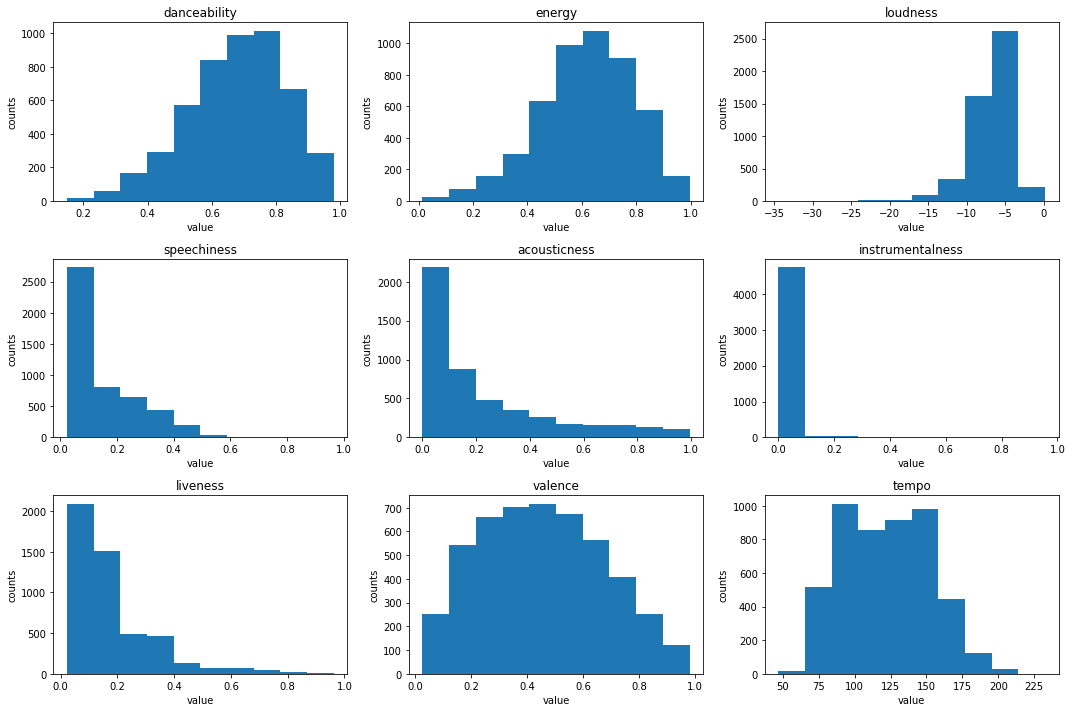

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,10)) # 3x3 grid of figures displaying distributions of audio features

for i, ax in enumerate(axes.flat):
    col = cont_cols[i]
    ax.set_title(col)
    ax.hist(unique_songs_df[col])
    ax.set_xlabel('value')
    ax.set_ylabel('counts')

fig.tight_layout()

plt.show()

We make a few observations:

* Speechiness, acousticness, and liveness are all skewed right. We can log-transform these variables to try and fix this.
* Almost every song has an instrumentalness value of ~ 0. This feature is clearly not predictive of a song's popularity -- we can drop this from our model.

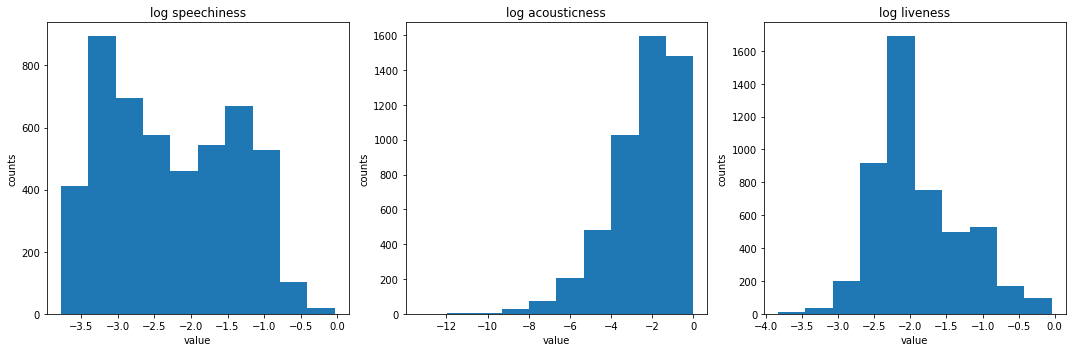

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5)) # display 3 figures
skewed_cols = ["speechiness", "acousticness", "liveness"] # aforementioned skewed-right audio features
for i, ax in enumerate(axes.flat):
    col = skewed_cols[i]
    ax.set_title("log " + col)
    ax.hist(np.log(unique_songs_df[col])) # log-transform these features
    ax.set_xlabel('value')
    ax.set_ylabel('counts')

fig.tight_layout()

plt.show()

Speechiness and liveness look a lot better than before, but even after the log transformation, acousticness is still skewed. __Let's only transform speechiness and liveness for our model__.

In [13]:
# drop 'instrumentalness' feature
cont_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness','valence', 'tempo']

In [17]:
song_lr_X = unique_songs_df[cont_cols]
song_lr_X.speechiness = unique_songs_df['speechiness'].map(lambda x: np.log(x)) # log-transform 'speechiness'
song_lr_X.liveness = unique_songs_df['liveness'].map(lambda x: np.log(x)) # log-transform 'liveness'
song_lr_X = song_lr_X.rename(columns = {'speechiness':'log_speechiness', 'liveness':'log_liveness'})
song_lr_days = np.log(unique_songs_df.days) # log-transform 'days'

In [15]:
song_days_model = LinearRegression().fit(song_lr_X, song_lr_days) # fit linear regression between our features and popularity measure
print(f"r2: {song_days_model.score(song_lr_X, song_lr_days)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_days_model.coef_)))

r2: 0.028969356152799164
coefficients:
{   'acousticness': 0.043499833923084555,
    'danceability': 1.6197668897177038,
    'energy': -1.1982944142661416,
    'log_liveness': -0.0346513106691415,
    'log_speechiness': -0.06384984308492044,
    'loudness': 0.082215678864477,
    'tempo': 0.0009576428649178721,
    'valence': -0.14612734660233936}


Clearly, with an $r^2$ of ~3%, it's clear to see that __this model isn't great__; these audio features are extremely weak predictors for how many days a song stays on the charts. Let's try other measures of popularity and see how the regression models do:

Let's try __measuring popularity using peak streams__ -- peak streams represent the maximum number of streams a song was streamed in a day while it was on the charts. It follows logically that if a song is more popular, then it would be streamed more frequently.

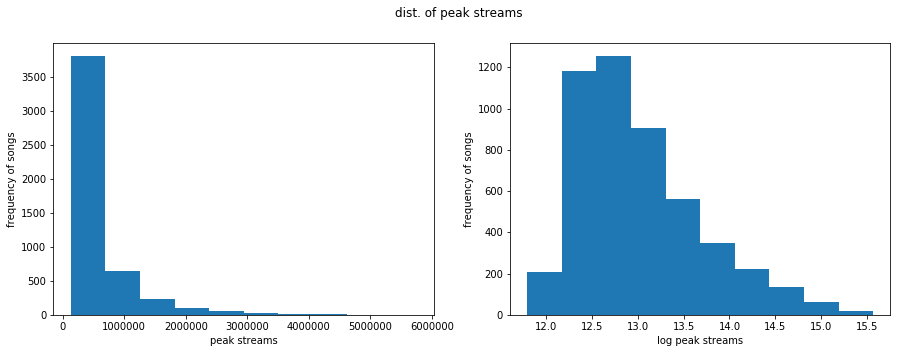

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # display side-by-side distributions of peak_streams and log(peak_streams)
ax1.hist(unique_songs_df.peak_streams)
ax1.set_xlabel("peak streams")
ax1.set_ylabel("frequency of songs")
ax2.hist(np.log(unique_songs_df.peak_streams))
ax2.set_xlabel("log peak streams")
ax2.set_ylabel("frequency of songs")
fig.suptitle("dist. of peak streams")
plt.show()

Again, the raw distribution is quite skewed, so we go with the log-transformed 'peak_streams' as our response variable.

In [19]:
song_lr_pstreams = np.log(unique_songs_df.peak_streams) # log-transformed 'peak_streams'
song_pstreams_model = LinearRegression().fit(song_lr_X, song_lr_pstreams) # fit lin. regression model
print(f"r2: {song_pstreams_model.score(song_lr_X, song_lr_pstreams)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_pstreams_model.coef_)))

r2: 0.023307864588005267
coefficients:
{   'acousticness': 0.06001225299927233,
    'danceability': 0.37410082411082995,
    'energy': -0.435216402301711,
    'log_liveness': 0.061533593914702915,
    'log_speechiness': 0.04191173067818476,
    'loudness': 0.010884453868463982,
    'tempo': 0.00041441322977403143,
    'valence': -0.04838235402324873}


__Again, our results are not great__ -- the $r^2$ in this model is actually lower than the $r^2$ in the previous model that predicted the number of days a song would stay on the charts.

So, let's again __adjust our popularity metric to median streams__ -- this is the median number of times a song was streamed while it was on the charts. Again, this metric should be a more robust and comprehensive measure of relative popularity: if a song is extremely popular one day but then fades away, that song would generally be considered to be less popular than a song that is consistently streamed a lot. 

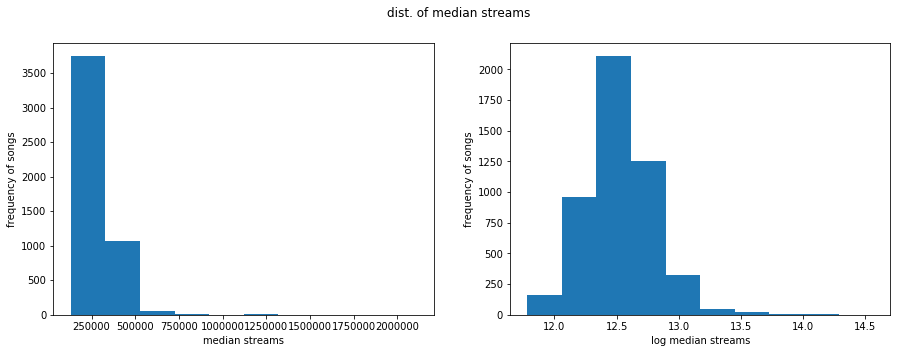

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # display side-by-side distributions of median_streams and log(median_streams)
ax1.hist(unique_songs_df.median_streams)
ax1.set_xlabel("median streams")
ax1.set_ylabel("frequency of songs")
ax2.hist(np.log(unique_songs_df.median_streams))
ax2.set_xlabel("log median streams")
ax2.set_ylabel("frequency of songs")
fig.suptitle("dist. of median streams")
plt.show()

In [21]:
song_lr_mstreams = np.log(unique_songs_df.median_streams) # log-transformed 'median_streams'
song_mstreams_model = LinearRegression().fit(song_lr_X, song_lr_mstreams) # fit lin. regression model
print(f"r2: {song_mstreams_model.score(song_lr_X, song_lr_mstreams)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_mstreams_model.coef_)))

r2: 0.01311352500392726
coefficients:
{   'acousticness': 0.0340905543467335,
    'danceability': 0.06746729869313116,
    'energy': -0.15607019629867178,
    'log_liveness': 0.020844185469213676,
    'log_speechiness': 0.012370290057327827,
    'loudness': 0.0025801683187485366,
    'tempo': -3.4665625547523036e-05,
    'valence': 0.04501279860025008}


Interestingly, this is the model with the __worst performance__. We note that our initial intuition was incorrect: 'energy' and 'danceability' are not strong predictors of popularity; in fact, none of the audio features are.


Unsurprisingly, this makes sense when we examine a correlation matrix between the audio features and the number of streams:

In [22]:
# examine correlation between numeric features
all_df.select_dtypes(exclude=['object']).corr()

,rank,streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
rank,1.000000,-0.725606,-0.083407,0.025537,0.018969,-0.015841,0.035518,-0.021400,0.020887,-0.012169,-0.007103,-0.002531,-0.006837,0.019675,-0.008730
streams,-0.725606,1.000000,0.075135,-0.028150,-0.009408,0.009745,-0.025449,0.019268,-0.017938,0.009392,0.039713,0.013407,0.006813,-0.026280,0.012693
danceability,-0.083407,0.075135,1.000000,-0.009159,-0.023191,0.073905,-0.083410,0.280305,-0.280773,-0.044703,-0.050056,0.228950,0.015487,-0.123850,0.100677
energy,0.025537,-0.028150,-0.009159,1.000000,0.015939,0.728078,0.007087,-0.061341,-0.455068,-0.091591,0.075383,0.359844,0.143536,0.036688,0.092241
key,0.018969,-0.009408,-0.023191,0.015939,1.000000,0.029376,-0.144063,-0.005674,0.015732,-0.019991,-0.034291,0.069289,-0.072700,-0.030794,-0.002441
loudness,-0.015841,0.009745,0.073905,0.728078,0.029376,1.000000,0.027741,-0.154172,-0.388458,-0.156116,0.013196,0.257109,0.094299,0.008850,0.091820
mode,0.035518,-0.025449,-0.083410,0.007087,-0.144063,0.027741,1.000000,-0.126489,0.007109,-0.025402,-0.003444,-0.010918,0.006295,0.038710,-0.015234
speechiness,-0.021400,0.019268,0.280305,-0.061341,-0.005674,-0.154172,-0.126489,1.000000,-0.133823,-0.035806,0.030043,0.015740,0.169778,-0.042255,0.066087
acousticness,0.020887,-0.017938,-0.280773,-0.455068,0.015732,-0.388458,0.007109,-0.133823,1.000000,0.106222,-0.072689,-0.062124,-0.159566,-0.038253,-0.076771
instrumentalness,-0.012169,0.009392,-0.044703,-0.091591,-0.019991,-0.156116,-0.025402,-0.035806,0.106222,1.000000,-0.009295,-0.101930,0.016459,0.038858,-0.040044


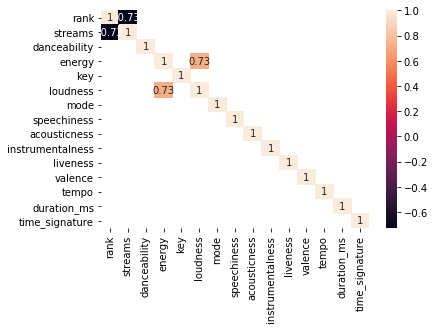

In [23]:
# let's see which numeric features are strongly correlated
sn.heatmap(all_df.select_dtypes(exclude=['object']).corr()[abs(all_df.select_dtypes(exclude=['object']).corr()) > 0.5], annot=True)
plt.show()

We see that the only feature in our dataset that correlates strongly with number of streams (measure of popularity) is 'rank' of the song (which is a sensible finding).

Clearly, none of the song's audio features are strong predictors of the song's success on the top charts. How about the artists themselves? __Does the success of an artist's past songs indicate anything about the success of their future songs?__

## Comparing the probabilities of having a rank 1 song

Let's compare the probability of an artist having another number one song given that they already have at least one to the probability of an artist having a number one song

In other words, we want to compare the conditional probability $Pr(\text{rank 1 song} | \text{has at least 1 rank 1 song})$ against the unconditional probability $Pr(\text{rank 1 song})$

In [151]:
print('Number of different artists with a #1 song:', len(unique_songs_df.loc[unique_songs_df.peak_rank == 1].artist.unique()))
print('Total number of artists included in dataset:', len(df_artist))
print('\nProportion of artists in dataset with a #1 song:', len(unique_songs_df.loc[unique_songs_df.peak_rank == 1].artist.unique())/len(df_artist))

Number of different artists with a #1 song: 40
Total number of artists included in dataset: 789

Proportion of artists in dataset with a #1 song: 0.050697084917617236


Wow, very few artists -- only around five percent -- have a number one song! This is not too surprising, however, since it feels like the same artists seem to appear over and over in the number one song position (e.g., Drake, Post Malone, etc.). Keep in mind that this dataset only includes songs and artists that reach the top 200 -- I can only imagine how small the proportion of __ALL__ artists that reach the number one song position must be.

Since we don't have data on the future popularity of artists' songs, __we will use the proportion of artists in the dataset with at least one #1 song (0.050697084917617236) as an estimate of the overall probability of having an artist having a #1 song, given that the artist has been featured on the top 200 charts.__

Now, let's examine the breakdown of number one songs by artist:

In [56]:
num_one_df = unique_songs_df.loc[unique_songs_df.peak_rank == 1, :]
num_one_pt = num_one_df.pivot_table(columns = 'artist', aggfunc = 'size')
print("artist:\t\tnumber of rank 1 songs\n")
print(num_one_pt)

artist:		number of rank 1 songs

artist
21 Savage             1
Ariana Grande         4
Arizona Zervas        1
Billie Eilish         2
Childish Gambino      1
DJ Khaled             1
DaBaby                1
Drake                 7
Ed Sheeran            2
Eminem                1
French Montana        1
Harry Styles          1
J. Cole               2
Jonas Brothers        1
Juice WRLD            1
Kanye West            3
Kendrick Lamar        1
Kodak Black           1
Lil Baby              2
Lil Nas X             3
Lil Peep              1
Lil Tecca             1
Lil Uzi Vert          5
Lil Wayne             1
Logic                 2
Luis Fonsi            1
Mariah Carey          1
Migos                 1
NAV                   1
Post Malone           8
Roddy Ricch           1
Selena Gomez          1
Shawn Mendes          1
Sheck Wes             1
Taylor Swift          5
The Weeknd            3
Travis Scott          3
Tyler, The Creator    1
XXXTENTACION          2
Young Thug            1


We observe that only some of the biggest names in music have a number one song. It appears that artists with more than one number one song are in an even more exclusive group, as we can see that very few artists have more than one number one hit.

__So, given that the artist has a number one song, just how many do they have in total?__

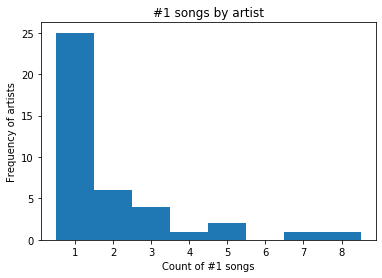

In [57]:
plt.hist(num_one_pt.values, bins = np.arange(0.5,9,1))
plt.title('#1 songs by artist')
plt.xlabel('Count of #1 songs')
plt.ylabel('Frequency of artists')
plt.show()

We confirm that the number of artists with a particular count of number one songs decreases significantly for each additional number one song.

So, we now model the probability of an artist having a number one song after having one already -- let's try using the Geometric model supported on the set {1, 2, 3, ...} (since there is no clear maximum to the number of number one songs artists can have) with different parameters and maximize the log-likelihood.

In [60]:
def geom_ll(x, p_list):
    """
    inputs: x: data on which MLE estimates should be computed
            p_list: list of success probabilities to compute log-likelihoods; MLE will be one of the elements in this list
    output: dict {p_list: corresponding loglikelihoods}, MLE of p
    """
    x = np.array(x) #so we can vectorize operations
    n = len(x)
    p_list = [round(p, 8) for p in p_list]
    ll = [n*np.log(p) + np.log(1-p)*sum(x-1) for p in p_list] #compute loglikelihoods at each p
    plt.plot(p_list, ll)
    plt.xlabel('p')
    plt.ylabel('Log-likelihood')
    plt.title("Success probability p vs log-likelihood")
    plt.show()
    return dict(zip(p_list, ll)), p_list[np.where(ll == max(ll))[0][0]]

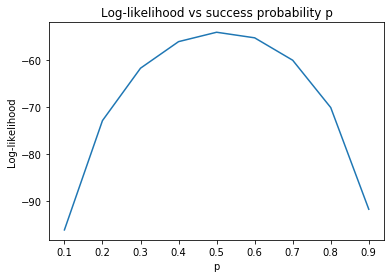

p's and corresponding loglikelihood values:
{   0.1: -96.10710331475921,
    0.2: -72.85697144730398,
    0.3: -61.71256004270928,
    0.4: -56.06300297807384,
    0.5: -54.06548008367574,
    0.6: -55.25207276185752,
    0.7: -60.01796432193486,
    0.8: -70.08438272506422,
    0.9: -91.7126541600868}

maximum likelihood estimation of p: 0.5


In [61]:
p_dict, p_maxll = geom_ll(num_one_pt.values, np.arange(.1, 1,.1))
print("p's and corresponding loglikelihood values:")
pp.pprint(p_dict)
print(f"\nmaximum likelihood estimation of p: {p_maxll}")

We see that the log-likelihood using a geometric model is maximized with success probability $p=0.5$. This model suggests that, __given an artist already has one song that has hit rank 1, the probability of having an additional rank 1 song comes down to approximately a coin flip.__

We note that there are some downfalls with using this model, such as the *lack of independence between trials* (whether or not an artist will get another number one song). There is also a potential issue with *a non-constant probability of getting an additional number one song*. These issues arise due to the fact that more popular artists tend to accumulate number one songs more frequently than less popular artists, as the less popular artists have difficulty establishing themselves. Likewise, if an artist stops making music or puts out a very popular album, the probability of an additional number one song changes.

Using the model, the fact that the probability an artist has an additional number one song after having at least one can simply come down to a coin flip is quite an interesting finding!

Thus, since the probability of an artist having another number one song (after having one already) is approximately 0.5 and since very few artists have a number one song (only around .05), __we conclude that the probability of an artist having a number one song if they already have one is about ten times greater than if they don't.__ In other words, if you already have a song that has hit #1, you are 10x more likely to have another song hit #1 relative to artists who don't already have a #1 song.

Clearly, the popularity of an artist's past songs is a relevant factor in determining the popularity of their future songs.

## Comparing the average number of rank 1 songs per artist
Now, let's consider a closely related problem: instead of comparing the probabilities of having rank 1 songs, let's compare __the number of rank 1 songs__ an artist is expected to have given that they already have at least one rank 1 song versus if they don't already have a rank 1 song in the time period of 3 years (the time span in our dataset). We can model this using a Poisson distribution and find a maximum likelihood estimate for the rate parameter $\lambda$.

However, these models are also imperfect as not all assumptions are met:
* Constant average rate of occurence across artists:
    * This assumption is tenuous at best -- trends change over time, so it would make sense for the current hot artists like Post Malone and Travis Scott to have more rank 1 songs than artists that are no longer trendy, such as Shawn Mendes and Ed Sheeran (also XXXTENTACION and Juice WRLD, but that's because they're dead).
* Independence of occurences:
    * This assumption is also not totally met: if an artist drops an album that has been highly anticipated, those songs will probably be more likely to reach rank 1.
    * The opposite is also true: if an artist releases a song/album that flops, hype around that artist may consequently die down, hindering the success of their future songs
    * Artists also sometimes go through hot streaks, where many of their songs in a short timeframe become extremely popular (ex: Lil Nas X's "Old Town Road" and "Panini").
    
With these shortcomings in mind, let's take a look at the results.

In [89]:
def poisson_ll(x, lmb_list):
    """
    inputs: x: data on which MLE estimates should be computed
            lmb_list: list of rate parameters lambda to compute log-likelihoods; MLE will be one of the elements in this list
    output: dict {lmb_list: corresponding loglikelihoods}, MLE of lambda
    """
    x = np.array(x) #so we can vectorize operations
    n = len(x)
    p_list = [round(lmb, 8) for lmb in lmb_list]
    
    ll = [(sum(x)*np.log(lmb)) - (n*lmb) - sum(np.log(x)) for lmb in lmb_list] #compute loglikelihoods at each lambda
    
    plt.plot(lmb_list, ll)
    plt.xlabel('lambda')
    plt.ylabel('Log-likelihood')
    plt.title("Lambda vs log-likelihood")
    plt.show()
    return dict(zip(lmb_list, ll)), lmb_list[np.where(ll == max(ll))[0][0]]

In [90]:
def compare_lambda(df, rank):
    """
    inputs: df: dataframe of unique songs
            rank: run comparison for number of songs that have reached this rank or above
    outputs: dict {
                    unconditioned: expected # songs per artist to reach this rank or higher 
                    conditioned: expected # songs per artist to reach this rank or higher GIVEN that they already have one
                    loglikelihoods: dict {list of lambdas: corresponding log likelihoods}
                    }
    """
    cnts = []
    for a in df_artist.artist.values:
        val = len(df.loc[(df.peak_rank <= rank) & (df.artist == a), :])
        cnts.append(val)
    baseline = np.mean(cnts) # number of songs that hit rank or higher averaged across artists; expected number of songs to hit rank or higher per artist
    data = df.loc[df.peak_rank <= rank, :].groupby('artist').size().values
    lmbs = np.arange(min(data), max(data), 1)
    mle_lambda = poisson_ll(data, lmbs)
    print(f"expected number of songs per artist to hit rank {rank} or higher:\n\t{baseline}")
    print(f"expected number of songs per artist to hit rank {rank} or higher, given that the artist already has at least one song at rank {rank} or higher:\n\t{mle_lambda[1]}")
    
    return {'unconditioned': baseline, 'conditioned':mle_lambda[1], 'loglikelihood':mle_lambda[0]}

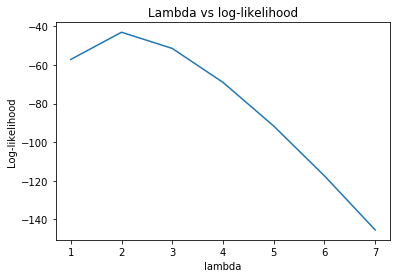

expected number of songs per artist to hit rank 1 or higher:
	0.09885931558935361
expected number of songs per artist to hit rank 1 or higher, given that the artist already has at least one song at rank 1 or higher:
	2


In [91]:
rank1_lambdas = compare_lambda(unique_songs_df, 1)

In this case, the baseline we used for comparison was the average number of songs per artist that hit rank 1. We can see that this number is extremely low: __we expect ~0.098 songs per artist to reach rank 1 in the span of 3 years, without any prior knowledge of the success of the aritst's previous songs.__

The second output represents the average number of songs per artist that hit rank 1 *given that the artist has at least one song at rank 1 or higher*. __In other words, if we know the artist already has at least one rank 1 song, then we expect them to have 2 songs in total to reach rank 1 or higher.__

We can see that __by incorporating prior knowledge about the artist's past performance, the expected number of rank 1 songs is ~20x higher than if we don't know anything about the their older songs.__

Clearly, an artist's track record is important in determining the success of their future songs.

We can generalize these models to different ranks as well. Let's look at the average number of songs per artist to reach rank 10 or higher and rank 25 or higher

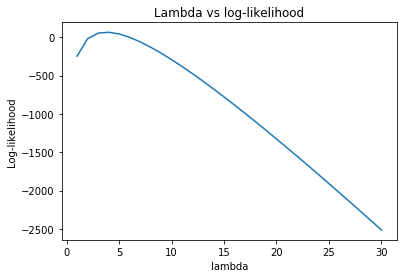

expected number of songs per artist to hit rank 10 or higher:
	0.6692015209125475
expected number of songs per artist to hit rank 10 or higher, given that the artist already has at least one song at rank 10 or higher:
	4


In [96]:
rank10_lambdas = compare_lambda(unique_songs_df, 10)

We can see that without taking into account the artist's track record, __an average artist is expected to have .67 songs hit rank 10 or higher. However, if we condition on the artist already having at least one song reach rank 10 or higher, the expected number of songs goes up significantly to 4 songs__, which is ~6x more.

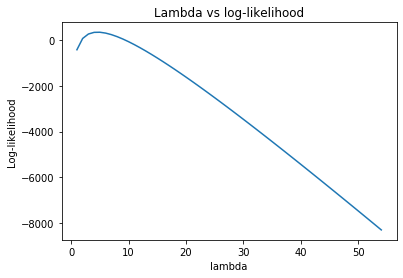

expected number of songs per artist to hit rank 25 or higher:
	1.3181242078580482
expected number of songs per artist to hit rank 25 or higher, given that the artist already has at least one song at rank 25 or higher:
	5


In [97]:
rank25_lambdas = compare_lambda(unique_songs_df, 25)

We reach similar conclusions when looking at the expected number of songs to hit rank 25 or higher: __the average artist is expected to have 1.32 songs achieve this, while artists with at least one rank 25+ song is expected to have 5 songs__, which is ~ 3.79x more.

It's interesting to note that the ratio of the conditioned expected number of songs to the unconditioned expected number of songs decreases as the threshold rank increases. This is makes sense: it is much more difficult to have a song reach rank 1 than it is to reach rank 10 (same with rank 10 vs rank 25). 

From the above analyses, it is clear to see that the creator of the song has a significant influence on the success of the song itself. Let's dig into the topic of artists further: __are there any interesting trends the songs by popular artists?__

# Artist Popularity and Their Usual Musical Attributes

* To perform further analysis, we must first restructure the data. Since we want to perform analysis on the level of artists (as opposed to individual songs), let's engineer some features that inform us about an artist's typical musical attributes. 


* Based on the data we currently have to work with, we quantify "typical musical attributes" by taking the median across each musical feature for each artist and quantify "overall popularity" by taking the sum of the number of days each of their songs was on the charts. Here is the flow of our idea:

      songs --> group by artist --> total number of days, median danceability, ..., median tempo

In [24]:
artist_dict = {'artist': [], 'total_days' : []}
a1 = {"median_" + c:[] for c in cont_cols}
artist_dict.update(a1)

unique_artists = unique_songs_df.artist.unique() # get each artist only once
for a in unique_artists: # for each artist
    subset = unique_songs_df.loc[unique_songs_df.artist == a, :]
    total = subset['days'].sum()
    artist_dict['total_days'].append(total)
    artist_dict['artist'].append(a)
    for k in cont_cols: # for each continuous musical feature
        artist_dict['median_' + k].append(subset[k].median())

In [25]:
df_artist = pd.DataFrame(artist_dict)
df_artist.head() # examine first five rows of dataframe

,artist,total_days,median_danceability,median_energy,median_loudness,median_speechiness,median_acousticness,median_liveness,median_valence,median_tempo
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.1325,0.3505,137.4800
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.1225,0.3525,118.9900
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.1250,0.2520,119.8290
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.1505,0.3980,104.4755
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.1110,0.2640,131.9860


As a first look at our new artist-level dataset, we will use __hypothesis tests__ to see if there are significant differences in typical musical attributes between the top 100 most popular artists (more popular) and the bottom 100 least popular (less popular) artists:

### Hypothesis tests
* We run two-sample hypothesis tests on the median audio feature values to see if the more popular artists' songs are different from the less popular artists' songs. For example, suppose we want to run a test on median tempo:
    * Let $med\_temp_{i}$ denote the median tempo of the $i^{th}$ artists' songs.
    * Let $\bar{TEMP}_{k}$ denote the median tempo of artists' songs in the $k^{th}$ averaged across all artists in that group. Let $k=1$ be the group containing the top 100 artists, and $k=2$ be the group containing the bottom 100 artists.
    * Similarly, let $s_{k}$ denote the standard deviation for the $k^{th}$ group, and let $n_k$ denote the number of artists in the $k^{th}$ group
    * Then:
        * $H_0: \bar{TEMP_{1}} = \bar{TEMP}_{2}$
        * $H_1: \bar{TEMP}_{1} \neq \bar{TEMP}_{2}$
        * $T = \frac{\bar{TEMP_{1}} - \bar{TEMP}_{2}}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$  
    
* This is the general form each test will take. Since we are running 8 simultaneous tests (1 for each audio feature) at $\alpha = .05$, we need to control the false-positive rate. To do this, we will apply a simple __Bonferroni correction__ such that $\alpha_{adjusted} = .05/8 = 0.00625$

In [26]:
# split artist dataset into top 100 vs bottom 100
top100 = df_artist.sort_values(by = 'total_days', ascending = False).iloc[:100, :]
bot100 = df_artist.sort_values(by = 'total_days', ascending = True).iloc[:100, :]
alpha = .05/8 # adj-pvalue
print(f"bonferroni-corrected alpha = .05/8 = {alpha}\n")

# perform 2-sample t-test with unequal variances on each audio feature
for col in top100.columns[2:]: # for each audio feature
    print(f"difference in... average {col}") # test name
    print(f"\th0: Group 1 average {col} == Group 2 average {col}") # H0
    print(f"\th1: Group 1 average {col} != Group 2 average {col}\n") # HA
    print(f"\tGroup 1: {top100[col].mean()}\t\t\t Group 2:{bot100[col].mean()}") # point estimates
    tt = ttest_ind(top100[col], bot100[col], equal_var = False) # perform 2-sample t-test (w/ unequal var)
    print(f"\tt = {tt[0]}") # test statistic
    print(f"\tp = {tt[1]}") # p-value
    print(f"\tsignificant: {tt[1]<=alpha}\n") # check if p-value is less than or equal to Bonferonni-adj alpha level

bonferroni-corrected alpha = .05/8 = 0.00625

difference in... average median_danceability
	h0: Group 1 average median_danceability == Group 2 average median_danceability
	h1: Group 1 average median_danceability != Group 2 average median_danceability

	Group 1: 0.7056749999999999			 Group 2:0.6379500000000001
	t = 3.9095841541689205
	p = 0.00013558167382297904
	significant: True

difference in... average median_energy
	h0: Group 1 average median_energy == Group 2 average median_energy
	h1: Group 1 average median_energy != Group 2 average median_energy

	Group 1: 0.6184350000000001			 Group 2:0.6690200000000002
	t = -2.575979759702809
	p = 0.01095289607509198
	significant: False

difference in... average median_loudness
	h0: Group 1 average median_loudness == Group 2 average median_loudness
	h1: Group 1 average median_loudness != Group 2 average median_loudness

	Group 1: -6.385944999999997			 Group 2:-6.588709999999996
	t = 0.6704547412280895
	p = 0.5035674002559152
	significant: False

* From the tests, we see that there are __significant differences in median danceability and speechiness of songs by the top 100 most popular artists (denoted as Group 1) are significantly different than those of songs by the bottom 100 artists (denoted as Group 2)__. Specifically:
    * Group 1 average median danceability > Group 2 average median danceability: Group 1 songs are significantly more dance-able/catchy/rhythmic 
    * Group 1 average median speechiness > Group 2 average median speechiness: Group 1 songs are significantly more wordy


* These findings make a lot of sense: songs will stay on the charts longer if they are more danceable/catchy, as people will listen to them over and over again. Additionally, these songs will be streamed on the radio and at parties/social gatherings more frequently, boosting those songs' popularity. As for speechiness, this also makes sense: in the past few years, rap songs have become quite mainstream, and those songs tend to be pretty wordy.

* This is pretty interesting: songs by the more popular artists tend to be different in danceability and speechiness than those by the less popular artists.

Let's taking a closer look at the top 100 group. Are there any similarities in the typical musical attributes of the top 100 most popular artists? 

__We use k-means clustering to group together similar artists based on their median audio feature values__ and examine the distribution of clusters in the entire artists dataset compared to the distribution of clusters in the top 100 most popular artist list.

### Exploratory data analysis, rescaling, and PCA
We start off with some __exploratory data analysis__: since we know there are some significant differences between songs by the most popular artists and songs by the least (relatively) popular artists, let's see if we can group together the artists by their typical musical features. This will help illustrate which artists tend to produce similar songs and help us find distinct patterns between artists' songs.

In [28]:
cont_cols

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'liveness',
 'valence',
 'tempo']

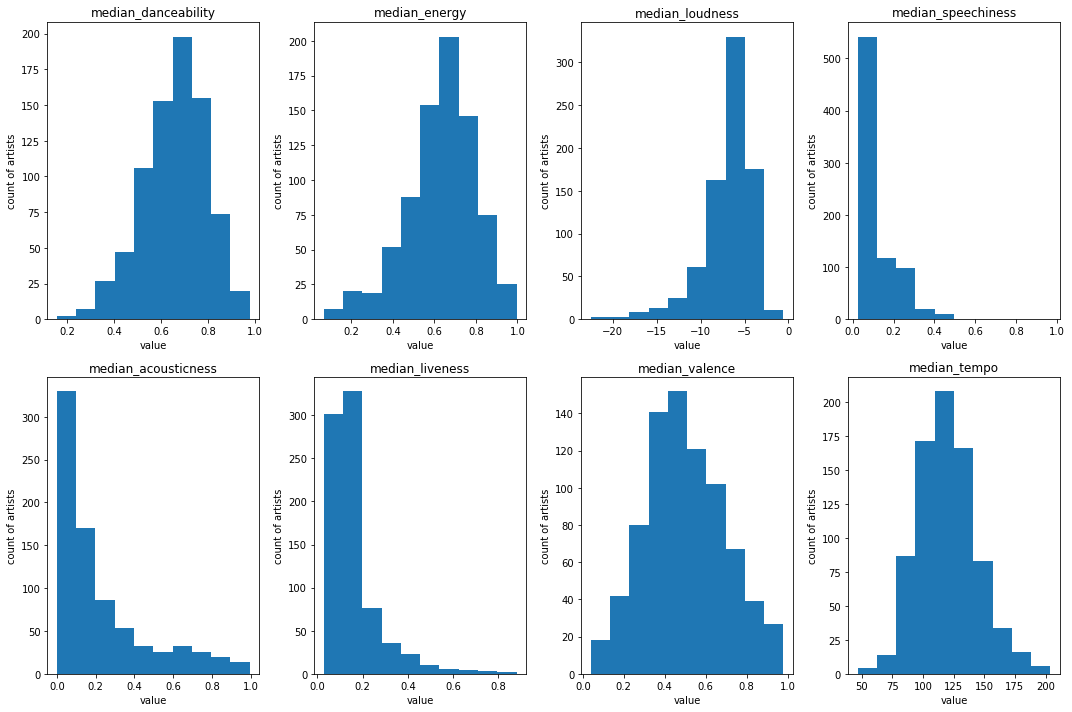

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10)) # 3x3 grid of distribution of median values for each feature by artist

for i, ax in enumerate(axes.flat):
    col = "median_" + cont_cols[i]
    ax.set_title(col)
    ax.hist(df_artist[col])
    ax.set_xlabel('value')
    ax.set_ylabel('count of artists')

fig.tight_layout()

plt.show()

* Since the audio features are on difference scales (ex: tempo is usually around 100 - 150 while valence is between 0 and 1), we don't want any single feature to bias the clustering results. So, let's __rescale the features__.

In [34]:
cluster_cols = df_artist.columns[2:]
print('Features to be clustered on:\n', cluster_cols.values)

Features to be clustered on:
 ['median_danceability' 'median_energy' 'median_loudness'
 'median_speechiness' 'median_acousticness' 'median_liveness'
 'median_valence' 'median_tempo']


In [35]:
X = df_artist[cluster_cols] # values to be clustered on

Let's use the RobustScaler method to decrease the impact of outliers. The following describes how RobustScaler works:  
* Let $C$ be the column to be rescaled and $q_x$ be the $x^{th}$ quantile of $C$:
    * For each $c_i$ in $C$:
        * $c_{i,scaled} = \frac{c_i - median(C)}{q_{75} - q_{25}}$

In [24]:
def scale(X):
    """
    inputs:   X: dataframe with columns of continuous features to be scaled
    
    returns:  X_scaled: dataframe with scaled columns
    """
    X_scaled = X.copy()    
    scaled_values = RobustScaler().fit_transform(X)
    
    for i in range(scaled_values.shape[1]):
        X_scaled.iloc[:,i] = scaled_values[:,i]

    return X_scaled

In [25]:
X_scaled = scale(X) # return our dataframe with scaled columns

To help us visualize this in 2D and to ameliorate the curse of dimensionality, let's __apply PCA to the scaled values using two components:__

In [26]:
def apply_pca(X, n):
    """
    inputs:   X: dataframe with scaled columns
              n: number of desired PCA components
              
    returns:  X_pca: copy of X with n PCA columns appended
    """
    pca = PCA(n_components=n)
    pc_cols = pd.DataFrame(pca.fit_transform(X), columns = [f"pc{i+1}" for i in range(n)])
    X_pca = pd.concat([X, pc_cols], axis = 1)        
    return X_pca

In [27]:
X_pca = apply_pca(X_scaled, 2) # return scaled dataframe with two PCA columns appended

### K-means clustering

Now that features have been scaled and PCA values have been created, __we are ready to cluster the artists__:

In [29]:
def choose_k(X, cols, fewest):
    """
    performs k-means clustering such that smallest cluster has at least "fewest" artists
    
    inputs:   X: dataframe with scaled columns 
              cols: columns on which clustering is to be performed
              fewest: smallest allowable cluster size
    
    returns:  out: dictionary {k: number of clusters, labels: cluster assignments, min_artists: size of smallest cluster}
    """

    df = X.loc[:,cols]
    
    ins = [] #inertias
    prev_labels = None
    min_artists = []
    k = 1
    
    while len(min_artists) == 0 or min_artists[-1] >= fewest:    
        #keep clustering while the size of the smallest cluster > specified minimum
        
        k += 1
        km = KMeans(n_clusters = k)
        km.fit(df)
        labels = pd.Series(km.labels_)
        cnt = labels.value_counts().min() #size of smallest cluster; ensure that this >= fewest


        if cnt < fewest:
            #if clustering with k clusters results in a cluster that is smaller than allowed, break out of the loop and 
            #return the data corresponding to k-1 clusters
            out = {'k':k-1, 'labels': prev_labels, 'min_artists': min_artists[-1]}
            break
        else: #update stored data, keep going
            min_artists.append(cnt)
            prev_labels = labels
            ins.append(km.inertia_)    
            
        
    xaxis = range(2, k)
    plt.plot(xaxis, ins, marker = 'x')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("inertia")
    plt.show()
    
    plt.plot(xaxis, min_artists, marker = 'x', label = 'smallest size')
    plt.plot(xaxis, np.array(min_artists)/np.array(xaxis), marker = 'o',label = 'avg size')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("cluster size")
    plt.legend()
    plt.show()
    
    return out

* When using k-means clustering, we generally seek to pick $k$ to be the number of clusters corresponding to the "elbow" in the plot to reduce overfitting while still sufficiently reducing the within-group sum of squares.   


* However, our approach for clustering in the context of this project is a bit different: since there are so many genres and sub-genres that artists can fall under, we want my clustering results to capture this granularity, which is why we did not choose k to be the "elbow" of the plot. __TL;DR: we overfit our model in order to capture all of the unique genres our artists can fall into__.


* That being said, we did not want to have dozens of clusters containing only a few artists, so we included a parameter in the clustering function to __allow the user to specify the fewest number of artists any cluster is allowed to have__. So, the above function increments $k$, runs k-means with $k$ clusters, and checks how many artists are in the smallest cluster. It returns $k$ and a vector of labels such that running k-means with $k$ clusters results in the smallest cluster size being greater than or equal to the minimum allowed cluster size, while running k-means with $k+1$ clusters results in fewer artists than allowed. 

*Note that running the function multiple times will give different results since cluster assignments are random.*

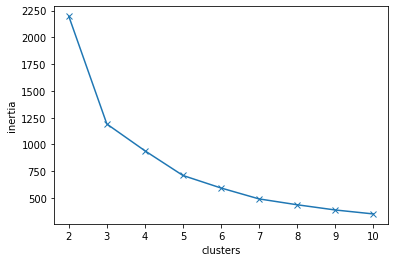

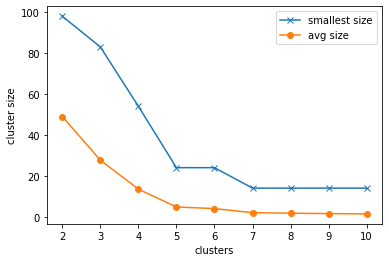

In [34]:
km_data = choose_k(X_pca, ['pc1', 'pc2'], 10) # run k-means clustering on our scaled dataframe s.t. smallest cluster has 10 artists

* In the above function call, we specified that the smallest cluster must have at least 10 artists (arbitrarily chosen). The first graph shows the inertia (sum of squared distances of points to their closest cluster center) for $1,...,k$ clusters, while the second graph shows the size of the smallest cluster for $1,...,k$ clusters.

In [35]:
k, labels, _ = km_data.values()

In [36]:
k #chosen k

10

In [37]:
labels.value_counts() #size of each cluster

8    193
1    168
7     98
3     96
9     68
0     62
6     41
5     31
2     18
4     14
dtype: int64

In [38]:
X_cluster = X_pca.copy()
X_cluster['cluster'] = labels

Our scaled values aren't easily interpretable, so we revert back to the original values and attach the artists' labels:

In [39]:
df_clustered = df_artist.copy()
df_clustered['cluster'] = labels
df_clustered.head() # examine first five rows in our dataframe

,artist,total_days,median_danceability,median_energy,median_loudness,median_speechiness,median_acousticness,median_liveness,median_valence,median_tempo,cluster
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.1325,0.3505,137.4800,1
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.1225,0.3525,118.9900,8
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.1250,0.2520,119.8290,8
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.1505,0.3980,104.4755,3
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.1110,0.2640,131.9860,1


In [40]:
def plot_clusters(df_labeled, k):
    """
    inputs:   df_labeled: dataframe with cluster assignments
              k: total number of clusters
    
    returns:  None (creates and shows scatterplot of cluster assignments)
    """
    for i in range(k):
        pts = df_labeled.loc[df_labeled.cluster == i, :]
        plt.scatter(pts["pc1"], pts["pc2"], label = i)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title = 'cluster',  bbox_to_anchor=(1.2, 1.0))
    plt.show()

Here's a plot showing the results of the clustering where each color represents a different cluster

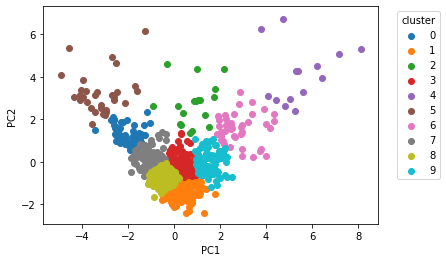

In [41]:
plot_clusters(X_cluster, k) # run plot_clusters function on our data w/ k = 10 clusters

* We can see our model overfitting, but again, this is the sacrifice we make to ensure we capture the true genres of each artist.

Since clustering results are random (labels assigned are arbitrary -- while the artist groupings are relatively consistent, the labels change each time you run the clustering algorithm), let's save the dataframe and perserve our findings.

In [42]:
df_clustered.to_csv("data/TopCharts_clustered_artists.csv", index = False) # write to CSV

In [43]:
def top_artists(df, k, n):
    """
    gives top n most popular artists in each cluster
    
    inputs:   df: dataframe with cluster assignments
              k: total number of clusters
              n: how many artists to show in each cluster    
    returns:  d: dictionary {cluster number: list of artists}
    """
    d = dict()
    for i in range(k):
        subset = df.loc[df.cluster == i, :].sort_values(by = "total_days", ascending = False)
        d[i] = list(subset.artist[:min(n, len(subset))])
    return d

These are the top 5 most popular artists in each cluster, as determined by the total number of days their songs were on the charts:

In [44]:
pp.pprint(top_artists(df_clustered, 10, 5))

{   0: ['Billie Eilish', 'Sam Smith', 'Joji', '6LACK', 'Lewis Capaldi'],
    1: ['Migos', 'Marshmello', 'Logic', 'DaBaby', '6ix9ine'],
    2: ['Lord Huron', 'Brenda Lee', 'Wham!', 'José Feliciano', 'The Jackson 5'],
    3: [   'Lil Uzi Vert',
           'Travis Scott',
           'Kendrick Lamar',
           'The Chainsmokers',
           'Future'],
    4: ['Steve Aoki', 'John Lennon', 'Skrillex', 'Powfu', 'FRENSHIP'],
    5: [   'Bing Crosby',
           'Frank Sinatra',
           'Nat King Cole',
           'Dean Martin',
           'Jeremy Zucker'],
    6: ['Lizzo', 'Famous Dex', 'Dustin Lynch', 'Lunay', 'Louis Tomlinson'],
    7: ['XXXTENTACION', 'Khalid', 'J. Cole', 'Lauv', 'Offset'],
    8: ['Post Malone', 'Drake', 'Juice WRLD', 'Ariana Grande', 'Ed Sheeran'],
    9: ['Luke Combs', 'Eminem', 'DJ Khaled', 'Panic! At The Disco', 'KYLE']}


For each cluster, let's examine the mean and median number of total days spent on the charts by the artists in that cluster:

In [141]:
for i in range(k): # for each cluster
    days = df_clustered.loc[df_clustered.cluster == i, 'total_days']
    print(f"cluster {i}:\n\taverage days: {days.mean()}\n\tmedian days: {days.median()}")

cluster 0:
	average days: 174.80645161290323
	median days: 8.0
cluster 1:
	average days: 205.9345238095238
	median days: 50.5
cluster 2:
	average days: 40.44444444444444
	median days: 14.5
cluster 3:
	average days: 389.9166666666667
	median days: 86.0
cluster 4:
	average days: 31.714285714285715
	median days: 7.5
cluster 5:
	average days: 61.03225806451613
	median days: 34.0
cluster 6:
	average days: 71.46341463414635
	median days: 17.0
cluster 7:
	average days: 300.7959183673469
	median days: 52.5
cluster 8:
	average days: 547.2331606217616
	median days: 86.0
cluster 9:
	average days: 179.83823529411765
	median days: 67.0


* Clearly, __artists in clusters 3 and 8 seem to spend more days on the charts than artists in other clusters__. Is this reflected in the distribution of clusters in the top 100 artists? Let's narrow our scope and develop these findings further:

### Representation of clusters in top 100 most popular artists:
Let's see if there are any clusters that are over/under-represented in the top 100 most popular artists:

In [36]:
def plot_cluster_barchart(subset_cnts, subset_name, k, compare, baseline_props = None):
    """
    plots cluster proportions
    
    inputs: subset_cnts: cluster frequencies in subset 
            subset_name: name of subset
            k: total number of clusters
            compare: True if want to compare to baseline proportions, else False
            baseline_props: baseline proportions for comparison
    
    returns: subset_heights: cluster proportions in subset
    """
    xaxis = np.array(range(k))
    
    n = sum(subset_cnts.values)
    subset_heights = [subset_cnts[i]/n if i in subset_cnts.index else 0 for i in range(k)]
    
    plt.bar(xaxis, subset_heights, .4, label = subset_name)
    plt.xlabel("cluster")
    plt.ylabel("prop")
    plt.title("distribution of clusters")
    if compare:
        plt.bar(xaxis+.4,baseline_props, .4, color='r',label='all')
        plt.legend()
        plt.xticks(xaxis+.4/2, xaxis)
    else:
        plt.xticks(xaxis)
    plt.show()
    
    return subset_heights


In [39]:
size_all = len(df_artist)
all_cnts = df_clustered.cluster.value_counts()
print("proportion of artists in each cluster:")
for i in range(10):
    print(f"\tcluster {i}: {round(all_cnts[i]/size_all, 4)}")

proportion of artists in each cluster:
	cluster 0: 0.0786
	cluster 1: 0.2129
	cluster 2: 0.0228
	cluster 3: 0.1217
	cluster 4: 0.0177
	cluster 5: 0.0393
	cluster 6: 0.052
	cluster 7: 0.1242
	cluster 8: 0.2446
	cluster 9: 0.0862


* These are the proportions we would expect to see. For example, if we were to take a sample of 100 artists out of all artists in the dataset, we would expect ~7 of them to belong to cluster 0.

We visualize these proportions in the following barchart

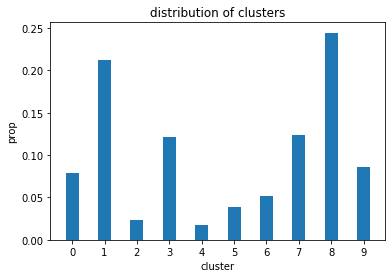

In [40]:
all_props = plot_cluster_barchart(df_clustered.cluster.value_counts(), "all", 10, False)

Now, lets take a look at the top 100 artists:

In [42]:
t100 = df_clustered.sort_values(by = 'total_days', ascending = False).iloc[:100, :]
t100_cnts = t100.cluster.value_counts()
t100_cnts

8    51
3    15
1    14
7     9
9     5
0     4
6     2
Name: cluster, dtype: int64

* Raw counts of clusters in top 100 artists. 51 of the top 100 artists are in cluster 8, 15 are in cluster 3, and so forth.

Distribution of clusters proportions among top 100 artists:

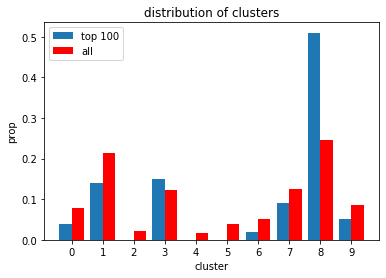

In [43]:
t100_props = plot_cluster_barchart(t100_cnts, "top 100", 10, True, all_props)

__In the top 100 artists, it looks like cluster 8 is extremely overrepresented (with the largest absolute difference in proportions being ~0.25) while the other clusters (except for cluster 3) seem to be underrepresented__. To validate our hypothesis that the observed distribution of clusters in the top 100 artists is different from the expected distribution, let's run a Chi Squared Goodness of Fit test as formal verification.

The hypotheses we will be testing are:
* $H_0:$ these observations are consistent with the expected distribution of cluster frequencies
* $H_1:$ these observations are NOT consistent with the expected distribution of cluster frequencies

In [55]:
def gof_test(subset_cnts, all_cnts, k, verbose = True):
    """
    performs chi-squared goodness of fit test
    
    inputs: subset_cnts: cluster frequencies in subset 
            all_cnts: cluster frequencies in entire dataset
            k: total number of clusters
            verbose: True if chi-squared stat, p-value, and test results to be printed, False if not
    
    returns: (chisq, p): chi-squared test statistic and corresponding p-value
    """
    
    n_sub = sum(subset_cnts.values)
    n_all = sum(all_cnts.values)
    
    observed_counts = np.array([subset_cnts[i] if i in subset_cnts.index else 0 for i in range(k)])
    expected_counts = np.array([all_cnts[i] * (n_sub/n_all) if i in all_cnts.index else 0 for i in range(k)])
    chisq, p = chisquare(observed_counts, f_exp=expected_counts)
    rej = "Yes" if p<.05 else "No"
    if verbose:
        print(f"Chisq: {chisq}\t\t Pr(>Chisq): {p}")
        print(f"Reject null?: {rej}")
    return chisq, p

In [56]:
t100_chisq, t100_p = gof_test(t100_cnts, all_cnts, 10) # run our GOF test

Chisq: 46.25617072397899		 Pr(>Chisq): 5.397277684535313e-07
Reject null?: Yes


* It looks like our intuitions from looking at the distributions were correct: the distribution of cluster frequencies in the top 100 most popular artists does not match the expected frequencies. 


* However, something else to consider is how likely it is for us to have gotten our results due to sheer chance. So, let's run some simulations to empirically determine how likely or unlikely our previous results are.

__Simulation analysis of the goodness-of-fit test results and conclusions:__

In [59]:
def sim_cluster_dist(cluster_df, n_iter, k):
    """
    performs simulation of cluster proportions; randomly chooses 100 artists from the entire dataset 
    and performs goodness of fit test
    
    inputs: cluster_df: entire dataset with cluster assignments
            n_iter: number of simulations to run
            k: total number of clusters
    returns: chisq_list: list of chi-squared test statistics from goodness of fit test (1 for each simulation)
             p_list: list of p-values, corresponds to chisq_list
             sim_props: cluster proportions in across all simulations
    """
    sim_cnts = np.zeros(k)
    p_list = []
    chisq_list = []
    n = len(cluster_df)
    for i in range(n_iter):
        idx = np.random.choice(range(n), 100, replace = False)
        vc = cluster_df.loc[idx, 'cluster'].value_counts()
        for c in vc.index:
            sim_cnts[c] += vc[c]
        x,p = gof_test(vc, all_cnts, k, verbose = False)
        chisq_list.append(x)
        p_list.append(p)
    
    sim_props = plot_cluster_barchart(pd.Series(sim_cnts), "simulated", k, True, all_props)
    return chisq_list, p_list, sim_props

Let's run 1000 simulations of 100 random samples from the entire artist dataset.

This histogram shows the proportion of clusters across all 1000 simulations of 100 samples. We can see that it almost perfectly matches the expected proportions.

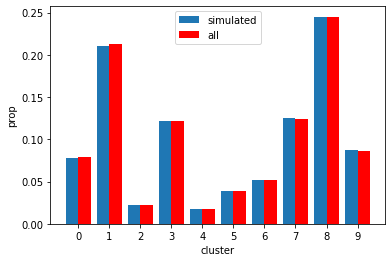

In [60]:
sim_data = sim_cluster_dist(df_clustered, 1000, 10)

We can see that 27 Type I errors (incorrectly rejecting the null hypothesis) have been made in 1000 simulations. Without even taking into considering the magnitude of our p-value for the goodness of fit test on the top 100 artists, we can see that our findings are already quite unlikely: there is only a 2.7% chance for our findings to have been a result of sheer chance.

In [61]:
print(f"number of times where the goodness of fit test rejects h0: {len(np.where(np.array(sim_data[1])<.05)[0])}")

number of times where the goodness of fit test rejects h0: 27


Now, let's take into consideration the magnitude of our findings by looking at the distribution of $\chi^2$ statistics in the simulation

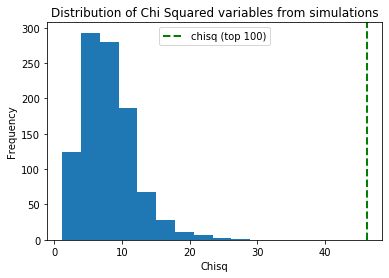

In [143]:
plt.hist(sim_data[0])
plt.axvline(x =t100_chisq, color = 'g', linestyle = 'dashed', linewidth = 2, label = 'chisq (top 100)')
plt.title("Distribution of Chi Squared variables from simulations")
plt.xlabel("Chisq")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [144]:
print(f"number of simulated chisq variable > chisq variable for top 100: {len(np.where(np.array(sim_data[0])>t100_chisq)[0])}")

number of simulated chisq variable > chisq variable for top 100: 0


This histogram shows the distribution of goodness of fit $\chi^2$ statistics from the simulation (for example, there are ~300 simulated $\chi^2$ variables around 5). 

In the above output, we can see that not a single simulation out of the 1000 simulations we ran produced results remotely close to the $\chi^2$ statistic we observed for the top 100 artists. This means that it is extremely unlikely for our findings to be an artifact of randomness -- __the differences between the distributions of clusters in the top 100 artists and the overall dataset is very significant.__ 

*So what does this mean?* 

Since cluster assignments are determined using each artist's typical musical attributes (median audio feature values across their songs), we can see that __most popular artists' typical musical attributes that are in some ways similar__, which explains why they all fall into a single cluster. 

However, since we cluster based on 2 principal components created from PCA, it should be mentioned that this similarity cannot necessarily attributed to just a single audio feature, but rather to a linear combination of audio features. Consequently, we cannot definitively tell what these features are, but let's take a look at the distribution of features in each cluster anyways.

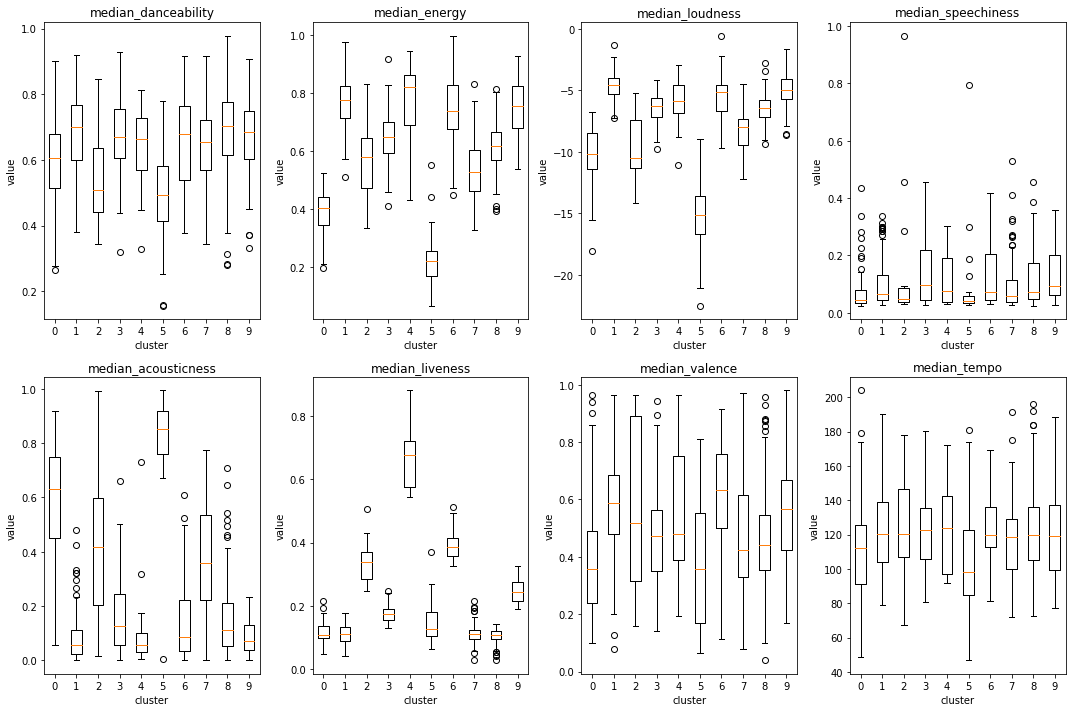

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for i, ax in enumerate(axes.flat):
    col = cluster_cols[i]
    
    data = [df_clustered.loc[df_clustered.cluster == i, col] for i in range(k)]
    ax.boxplot(data)
    ax.set_xlabel("cluster")
    ax.set_ylabel("value")
    ax.set_xticklabels(list(range(k)))
    ax.set_title(col)

fig.tight_layout()

plt.show()

Although we may not be able to empirically determine *how* the top 100 artists' typical musical attributes are similar , the fact these similarities exist is very interesting.